<a href="https://colab.research.google.com/github/AntonioMastroianni/Text_Mining/blob/main/Text_Mining_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gzip
nltk.download('punkt')
nltk.download('stopwords')
import string
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam



#download(stopwords)

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
sms = pd.read_csv("/content/gdrive/MyDrive/Materiale Text Mining/spam.csv", encoding='latin-1')
sms.dropna(how="any", inplace=True, axis=1)
sms.columns = ['label', 'message']

sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# load nltk's English stopwords as variable called 'stopwords'
sms['message'] = sms['message'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # Removing Puctuation
stopwords = nltk.corpus.stopwords.words('english')
more_stopwords = ['u', 'm', 'c', 'ur', 'dont', 'doin', 'ure', 'im', 'ure', 'n',"'","i'm", "r", "v", "ill"]
stop_words = stopwords + more_stopwords

In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in sms['message']:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'messages', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 82453 items in vocab_frame


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.4,
                                 min_df=2, stop_words=stop_words,
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

tfidf_matrix = tfidf_vectorizer.fit_transform(sms['message']) #fit the vectorizer to messages

print(tfidf_matrix.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'m", "'s", 'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'might', 'must', "n't", 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'veri', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn(


(5572, 8862)


In [11]:
terms = tfidf_vectorizer.get_feature_names_out()

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize lists to store silhouette scores and Davies-Bouldin scores
k_means_silhouette_scores = []
k_means_davies_bouldin_scores = []

# Specify the range of clusters (2 to 40)
for n_clusters in range(2, 41):
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(tfidf_matrix, cluster_labels)
    k_means_silhouette_scores.append(silhouette_avg)

    # Calculate Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), cluster_labels)
    k_means_davies_bouldin_scores.append(davies_bouldin)

# Convert lists to NumPy arrays for easier analysis if needed
k_means_silhouette_scores = np.array(k_means_silhouette_scores)
k_means_davies_bouldin_scores = np.array(k_means_davies_bouldin_scores)

# Print or analyze the results as needed
for n_clusters, silhouette, davies_bouldin in zip(range(2, 41), k_means_silhouette_scores, k_means_davies_bouldin_scores):
    print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette}, Davies-Bouldin Index: {davies_bouldin}")

In [ ]:
import matplotlib.pyplot as plt

# Assuming silhouette_scores and davies_bouldin_scores are already computed

# Normalize the scores for better visualization
normalized_k_means_silhouette = (k_means_silhouette_scores - min(k_means_silhouette_scores)) / (max(k_means_silhouette_scores) - min(k_means_silhouette_scores))
normalized_k_means_davies_bouldin = (k_means_davies_bouldin_scores - min(k_means_davies_bouldin_scores)) / (max(k_means_davies_bouldin_scores) - min(k_means_davies_bouldin_scores))

# Plotting Silhouette Score and Davies-Bouldin Index on the same graph with secondary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Silhouette Score on the primary y-axis
ax1.plot(range(2, 41), normalized_k_means_silhouette, label='Silhouette Score', marker='o', color='blue')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Silhouette Score (Normalized)', color='blue')
ax1.tick_params('y', colors='blue')

# Create a secondary y-axis for Davies-Bouldin Index
ax2 = ax1.twinx()
ax2.plot(range(2, 41), normalized_k_means_davies_bouldin, label='Davies-Bouldin Index', marker='o', color='orange')
ax2.set_ylabel('Davies-Bouldin Index (Normalized)', color='orange')
ax2.tick_params('y', colors='orange')

# Draw a red vertical line at 31 clusters
plt.axvline(x=31, color='red', linestyle='--', label='Selected Clusters')

# Customize the plot
plt.title('Clustering Evaluation Metrics vs. Number of Clusters')
fig.tight_layout()
plt.show()

In [46]:
num_clusters = 31

km = KMeans(n_clusters=num_clusters, n_init = 10, random_state=42)

km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [47]:
clusters = km.labels_.tolist()

In [48]:
messages = {'message': sms['message'], 'cluster': clusters}

frame = pd.DataFrame(messages, columns = ['message','cluster'])

In [49]:
message_counts = frame['cluster'].value_counts()

In [50]:
message_counts

21    2055
1      298
15     222
29     168
10     165
8      161
26     159
18     157
12     149
3      141
9      138
28     134
6      131
2      127
19     126
4      118
5      106
14     103
11     101
25      91
22      88
23      88
0       87
27      87
30      84
20      65
13      62
24      59
16      47
7       38
17      17
Name: cluster, dtype: int64

In [51]:
silhouette_avg = silhouette_score(tfidf_matrix, clusters)
silhouette_avg

0.022207119833070957

In [52]:
from sklearn.metrics import davies_bouldin_score
davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), clusters)
print(f"Davies-Bouldin Index: {davies_bouldin}")

Davies-Bouldin Index: 6.379627364731047


Top terms per cluster:

Cluster 0 words: still, tonight, around, still, still, come, still, still


Cluster 1 words: getting, free, mobile, call, reply, phone, nokia, txt


Cluster 2 words: ok, ok, lor, thanx, ok, ok, prob, yup


Cluster 3 words: ltgt, ltgt, mins, like, like, ltgt, minute, say


Cluster 4 words: text, stop, cool, free, call, aight, cool, text


Cluster 5 words: hey, leaving, yup, leaving, house, meet, next, ask


Cluster 6 words: well, night, last, sleeping, last, good, times, good


Cluster 7 words: class, go, app, day, come, day, app, ltgt


Cluster 8 words: one, day, great, great, wishes, hope, one, hope


Cluster 9 words: got, ta, got, ive, job, ive, yeah, meh


Cluster 10 words: come, come, home, times, tomorrow, want, want, come


Cluster 11 words: see, bit, see, didnt, tomo, want, see, want


Cluster 12 words: call, please, please, urgent, customer, message, service, collected


Cluster 13 words: prize, claim, guaranteed, call, guaranteed, prize, only, valid


C

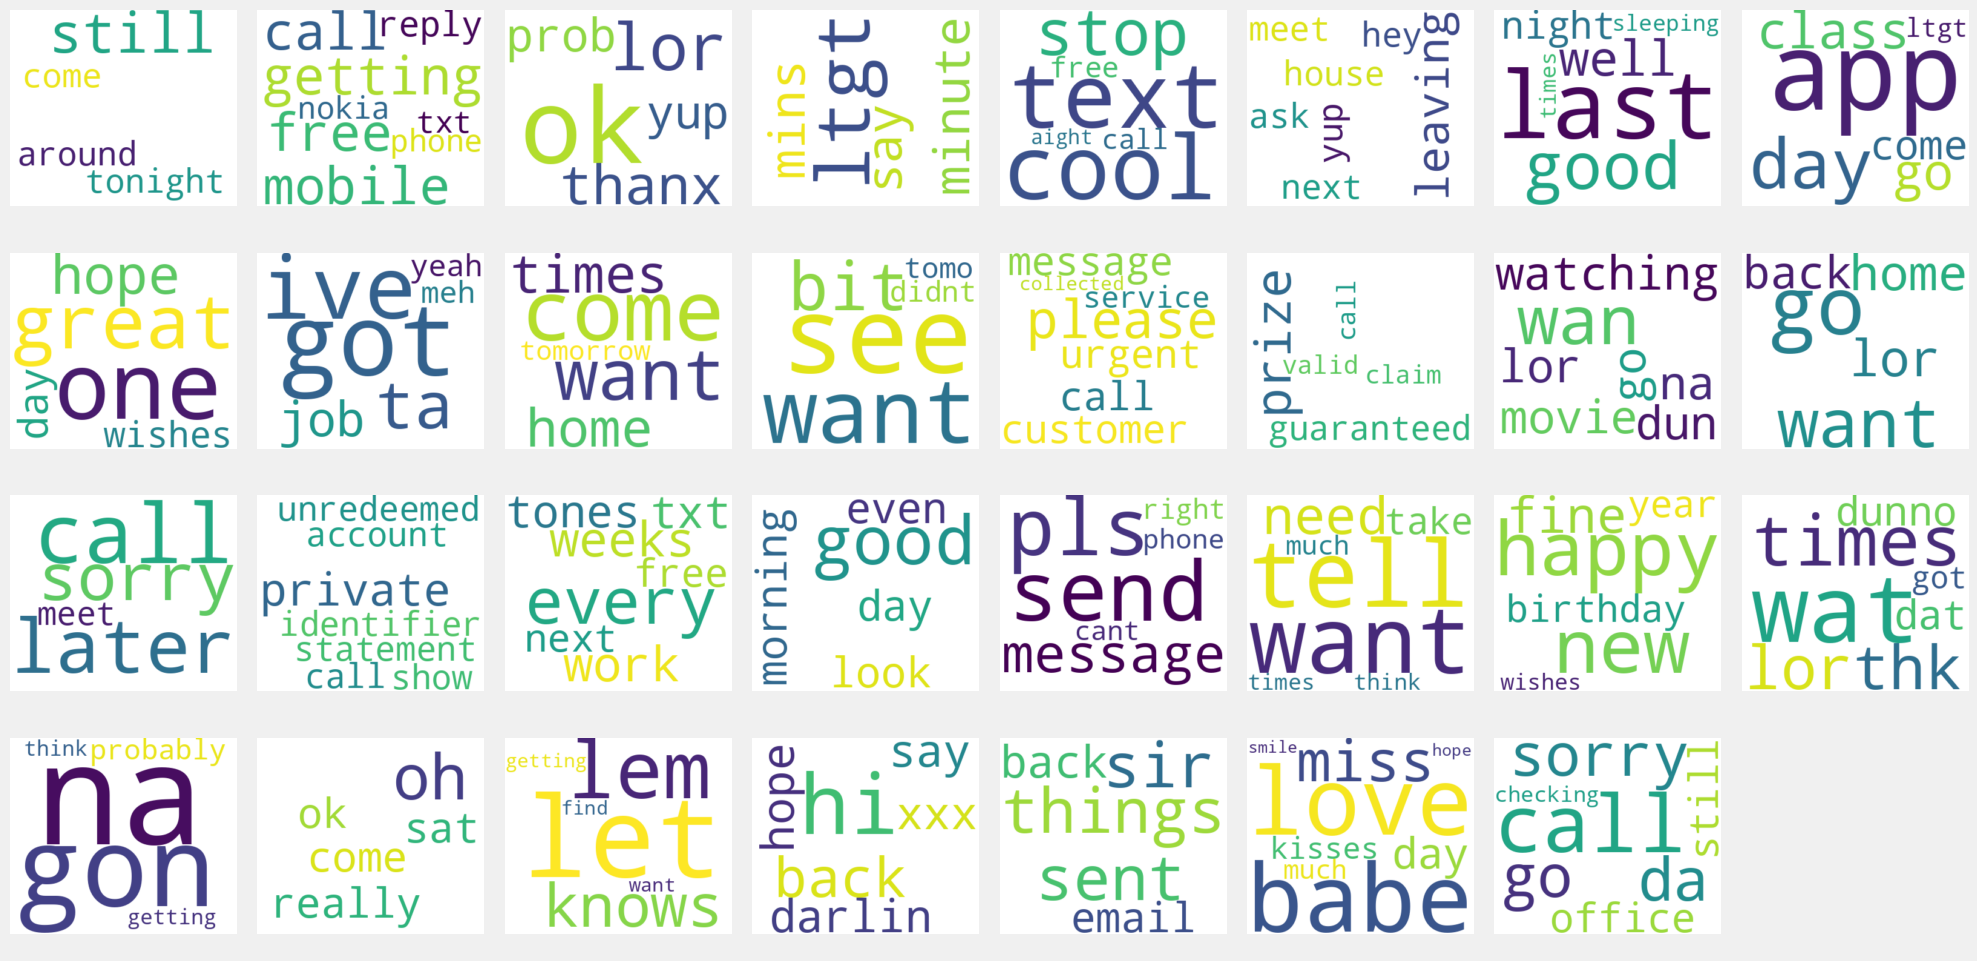

In [66]:
from __future__ import print_function
from wordcloud import WordCloud
import matplotlib.pyplot as plt

print("Top terms per cluster:")
print()
# Sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

# Create a list to store the terms for each cluster
all_cluster_terms = []

# Create subplots for each cluster
fig, axes = plt.subplots(4, 8, figsize=(20, 10), sharex=True, sharey=True)  # Switched 4 and 8
axes = axes.flatten()

for i in range(num_clusters):
    print("Cluster %d words: " % i, end='')

    # Collect terms without 'b' prefix in a list
    cluster_terms = []
    for ind in order_centroids[i, :8]:  # Replace 8 with the desired number of words per cluster
        term = vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0]
        cluster_terms.append(term)

    # Print the terms without 'b' prefix
    print(', '.join(cluster_terms))
    print()  # add whitespace
    print()  # add whitespace

    # Append the terms for the current cluster to the list
    all_cluster_terms.extend(cluster_terms)

    # Create a word cloud for the current cluster
    wordcloud = WordCloud(width=375, height=325, background_color='white').generate(' '.join(cluster_terms))

    # Plot the word cloud on the corresponding subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')

# Remove grid and numbers for all subplots
for ax in axes:
    ax.axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


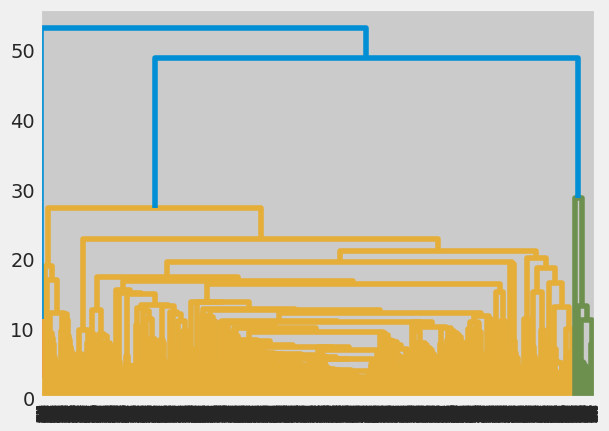

In [25]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
import scipy.cluster.hierarchy as sch

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
hclusters = fcluster(linkage_matrix, t=13.8, criterion='distance');
dendrogram = sch.dendrogram(linkage_matrix)
plt.show()

In [21]:
# Create a DataFrame with document and cluster labels
df_clusters = pd.DataFrame({'sms': sms['message'], 'cluster': hclusters})

# Analyze each cluster and find the top 5 words
for cluster_num in range(1, max(hclusters) + 1):
    # Filter data for the current cluster
    cluster_data = df_clusters[df_clusters['cluster'] == cluster_num]

    # Compute TF-IDF for the cluster
    cluster_tfidf_matrix = tfidf_vectorizer.transform(cluster_data['sms'])

    # Sum the TF-IDF scores for each term in the cluster
    term_sum = cluster_tfidf_matrix.sum(axis=0)

    # Get the indices of the top 5 terms
    top_term_indices = term_sum.argsort()[0, -5:]

    # Get the feature names (terms) from the TF-IDF vectorizer
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get the top 5 terms
    top_terms = [str(feature_names[index]) for index in top_term_indices]

    # Count of messages in the cluster
    message_count = len(cluster_data)

    # Print the results for each cluster
    print(f"\nCluster {cluster_num}:")
    print(f"  Top 5 terms: {', '.join(top_terms)}")
    print(f"  Messages count: {message_count}")


Cluster 1:
  Top 5 terms: [['call' 'sorri' 'later' 'sorri call' 'call later']]
  Message count: 45

Cluster 2:
  Top 5 terms: [['show unredeem' 'privat' 'statement' 'privat account'
  'account statement']]
  Message count: 17

Cluster 3:
  Top 5 terms: [['valid' 'prize' 'guarante' 'guarante call' 'prize guarante']]
  Message count: 22

Cluster 4:
  Top 5 terms: [['claim' 'prize' 'pleas' 'pleas call' 'call']]
  Message count: 276

Cluster 5:
  Top 5 terms: [['like' 'like ltgt' 'min' 'ltgt min' 'ltgt']]
  Message count: 138

Cluster 6:
  Top 5 terms: [['stop' 'repli' 'txt' 'week' 'free']]
  Message count: 248

Cluster 7:
  Top 5 terms: [['happi' 'happi new' 'year' 'new year' 'new']]
  Message count: 35

Cluster 8:
  Top 5 terms: [['think' 'would like' 'would' 'feel' 'like']]
  Message count: 84

Cluster 9:
  Top 5 terms: [['shall' 'time get' 'didnt get' 'time' 'get']]
  Message count: 97

Cluster 10:
  Top 5 terms: [['time' 'think' 'well' 'love' 'good']]
  Message count: 530

Cluster 11

In [26]:
hsilhouette_avg = silhouette_score(tfidf_matrix.toarray(), hclusters)
print(f"\nSilhouette Score for the Hierarchical Clustering: {hsilhouette_avg}")


Silhouette Score for the Hierarchical Clustering: 0.009792727045172141


In [27]:
from sklearn.metrics import davies_bouldin_score
h_davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), hclusters)
print(f"Davies-Bouldin Index: {h_davies_bouldin}")

Davies-Bouldin Index: 6.077576947490792


In [41]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

# Try different cuts and evaluate clustering quality
for height in np.arange(6, 15, 0.45):  # Adjust the height values based on dendrogram visualization
    # Cut the dendrogram to create clusters
    hier_clusters = fcluster(linkage_matrix, t=height, criterion='distance')

    # Print the number of clusters
    hier_num_clusters = len(set(hier_clusters))
    print(f"For cut at height {height}, Number of Clusters: {hier_num_clusters}")

    # Evaluate clustering quality using silhouette score
    hier_silhouette_avg = silhouette_score(tfidf_matrix, hier_clusters)
    print(f"For cut at height {height}, Silhouette Score: {hier_silhouette_avg}")

    # Optionally, evaluate using other indices like Davies-Bouldin Index
    hier_davies_bouldin = davies_bouldin_score(tfidf_matrix.toarray(), hier_clusters)
    print(f"For cut at height {height}, Davies-Bouldin Index: {hier_davies_bouldin}")

    print()

For cut at height 6.0, Number of Clusters: 188
For cut at height 6.0, Silhouette Score: 0.033105850865136656
For cut at height 6.0, Davies-Bouldin Index: 3.922292298396019

For cut at height 6.45, Number of Clusters: 159
For cut at height 6.45, Silhouette Score: 0.031089852395433215
For cut at height 6.45, Davies-Bouldin Index: 4.161521090186128

For cut at height 6.9, Number of Clusters: 133
For cut at height 6.9, Silhouette Score: 0.027117558809842228
For cut at height 6.9, Davies-Bouldin Index: 4.414983155159964

For cut at height 7.3500000000000005, Number of Clusters: 118
For cut at height 7.3500000000000005, Silhouette Score: 0.029458019591954893
For cut at height 7.3500000000000005, Davies-Bouldin Index: 4.364829156199009

For cut at height 7.800000000000001, Number of Clusters: 108
For cut at height 7.800000000000001, Silhouette Score: 0.029523354397102065
For cut at height 7.800000000000001, Davies-Bouldin Index: 4.505338200645274

For cut at height 8.25, Number of Clusters: 9